### Food Prices Preprocessing

Source:	EWURA, FPMA, MITI, MITM, Regional Agricultural Trade Intelligence Network via FAO: GIEWS
Contributor:WFP - World Food Programme
Time Period of the Dataset: January 15, 2006-February 15, 2024 ... More
Expected Update Frequency:Every month 
Location:  	
United Republic of Tanzania
Visibility 	
Public
License 	Creative Commons Attribution for Intergovernmental Organisations
Methodology 	Registry
Caveats / Comments 	

Although the frequency of updates is set to every month, updates may occur more or less frequently
[cite](https://data.humdata.org/dataset/wfp-food-prices-for-united-republic-of-tanzania) on 18th April 2024


[asap](https://data.humdata.org/dataset/asap-hotspots-monthly)



You can look this later on

[Crop Production in Tanzania](https://tasis.nbs.go.tz/statHtml/statHtml.do?orgId=255&tblId=DT_SA_077&language=en&conn_path=I3)

## Import Libraries

In [4]:
import pandas as pd
import os
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

### Helper Function

In [26]:
def data_exploration(df, columns_to_explore):
    
    '''
    Perform data exploration on specified columns of a DataFrame and print the results.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    columns_to_explore (list): A list of column names to explore.
    
    '''
    for column in columns_to_explore:
        # Get unique values
        unique_values = df[column].unique()
        
        #value_counts = df[column].value_counts()
        
        # Number of unique values
        num_unique_values = len(unique_values)

        # Count missing values
        missing_values_count = df[column].isnull().sum()

        # Print exploration results
        print(f"Column Name : {column}")
        print("=================================================================================")
        print(f"Unique values: {unique_values}")
        print(f"Number of unique values: {num_unique_values}")
        print(f"Missing values count: {missing_values_count}")
        print("=================================================================================") 

In [27]:
def update_food_price(df):
    '''
    Update the food prices and unit for those food items with 100 KG,
    Converting the Unit to KG and calculate the price and USD prices per KG

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing columns 'unit', 'price', and 'usd_price'.

    Returns:
    pandas.DataFrame: A new DataFrame with unit converted to KG and prices and USD price per KG
    
    '''
    
    # Identify rows where the unit is "100 KG"
    mask = df['unit'] == '100 KG'

    # Calculate the conversion rate based on the initial prices
    conversion_rate = df.loc[mask, 'price'] / df.loc[mask, 'usd_price']

    # Convert the price to price per KG
    df.loc[mask, 'price'] /= 100
    df.loc[mask, 'unit'] = 'KG'

    # Calculate the new price of USD per KG
    df.loc[mask, 'usd_price'] = df.loc[mask, 'price'] / conversion_rate

    return df


In [28]:
def plot_food_price_trends(dataframe, year, food_items=None, district=None, save_path=None):
    """
    Plot trends of food prices for specified year, food items, and district.

    Args:
        dataframe (DataFrame): The input dataframe.
        year (int): The year to visualize the trends.
        food_items (list of str, optional): List of food items to visualize. If None, all food items will be considered.
        district (str, optional): The name of the district to visualize. If None, data for all districts will be considered.
        save_path (str, optional): File path to save the graph. If None, the graph will not be saved.

    Returns:
        None
    """
    # Filter dataframe based on the specified year
    df_year = dataframe[dataframe['year'] == year]

    # Filter dataframe based on food items if specified
    if food_items:
        df_year = df_year[df_year['food_item'].isin(food_items)]

    # Filter dataframe based on district if specified
    if district:
        df_year = df_year[df_year['district'] == district]

    # Group dataframe by food item
    grouped = df_year.groupby('food_item')

    plt.figure(figsize=(8, 6))

    # Plot trends for each food item
    for food_item, group in grouped:
        plt.plot(group["month"], group["price"], marker='o', label=food_item)

    # Add title with district name if provided
    title = f"Price Trends in {year}"
    if district:
        title += f" - District: {district}"
    plt.title(title)

    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}/{year}_trend.png")
    else:
        plt.show()

In [29]:
def merge_data(df_prices, df_district):
    '''
    Merges food prices data with district information.

    Parameters:
    - df_prices (DataFrame): A DataFrame containing food prices data.
    - df_district (DataFrame): A DataFrame containing district information.

    Returns:
    pandas.DataFrame: Merged dataframe containing district information and food prices.
    '''
    # Merge dataframes based on region and district columns
    merged_df = pd.merge(df_district, df_prices, on=['region', 'district'], how='left')
       
    return merged_df


In [30]:
def save_interpolated_data(df, output_file_path):
    """
    Save the interpolated data to a CSV file.
    """
    try:
        df.drop(columns=['latitude', 'longitude'], inplace=True)
        #df.to_csv(output_file_path, index=False)
        df.to_excel(output_file_path, index=False)
        print(f"Interpolated data has been successfully saved at {output_file_path}")
    except Exception as e:
        print(f"An error occurred while saving the file: {e}")

In [31]:
def process_food_prices(food_prices_files, shapefile_path, output_dir, n_neighbors=5):
    """
    Main function to process food prices, perform spatial interpolation, pivot the data, and save it to CSV files.

    Args:
        food_prices_files (list of str): List of paths to the food prices CSV files.
        shapefile_path (str): Path to the shapefile containing region and district data.
        output_dir (str): Directory to save the output CSV files.
        n_neighbors (int): Number of neighbors to use for kNN interpolation.
    """
    complete_time_df, gdf = generate_complete_time_series(shapefile_path)
    
    for food_prices_path in food_prices_files:
        try:
            # Read the food prices data
            food_prices_df = pd.read_csv(food_prices_path)
            
            if food_prices_df.empty:
                print(f"No data available to process in {food_prices_path}.")
                continue
            
            # Merge the data with the complete time series and shapefile
            food_prices_df = update_food_price(food_prices_df)
            prepared_df = merge_and_prepare_data(food_prices_df, complete_time_df, gdf)

            # Pivot the data for 'price'
            pivoted_price_df = pivot_data(prepared_df, 'price')
            # Pivot the data for 'usd_price'
            pivoted_usd_price_df = pivot_data(prepared_df, 'usd_price')

            # Perform interpolation on the pivoted data
            interpolated_price_df = interpolate_values(pivoted_price_df, n_neighbors)
            interpolated_usd_price_df = interpolate_values(pivoted_usd_price_df, n_neighbors)

            # Generate output file names
            base_name = os.path.splitext(os.path.basename(food_prices_path))[0]
            #price_output_file_path = os.path.join(output_dir, f'{base_name}_price.csv')
            price_output_file_path = os.path.join(output_dir, f'{base_name}_price.xlsx')
            usd_price_output_file_path = os.path.join(output_dir, f'{base_name}_usd_price.xlsx')

            # Save the interpolated data to separate files
            save_interpolated_data(interpolated_price_df, price_output_file_path)
            save_interpolated_data(interpolated_usd_price_df, usd_price_output_file_path)

        except Exception as e:
            print(f"An error occurred while processing {food_prices_path}: {e}")

## Interpolate Food Prices Functions

In [32]:
def generate_complete_time_series(shapefile_path):
    """
    Generate a complete time series from 2005 to 2023 for each valid region-district combination.
    """
    # Load shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Re-project geometries to a suitable projected CRS
    gdf = gdf.to_crs(epsg=3857)  # Using EPSG:3857 (Web Mercator)
    
    # Calculate centroid coordinates for each district
    gdf['centroid'] = gdf.geometry.centroid
    gdf['latitude'] = gdf.centroid.y
    gdf['longitude'] = gdf.centroid.x
    
    # Normalize the column name for region/province
    if 'province' in gdf.columns:
        area_col = 'province'
    elif 'region' in gdf.columns:
        area_col = 'region'
    else:
        raise ValueError("Neither 'region' nor 'province' column found in the shapefile.")
    
    # Generate a list of unique region-district combinations
    region_district_combinations = gdf[[area_col, 'district']].drop_duplicates()

    # Create a complete time series for each region-district combination
    years = range(2005, 2024)
    months = range(1, 13)
    
    # Create a list to store DataFrames for each region-district combination
    dfs = []
    for _, row in region_district_combinations.iterrows():
        region = row[area_col]
        district = row['district']
        index = pd.MultiIndex.from_product([[region], [district], years, months], names=[area_col, 'district', 'year', 'month'])
        df = pd.DataFrame(index=index).reset_index()
        dfs.append(df)

    # Concatenate all DataFrames to create the final complete time series DataFrame
    complete_time_df = pd.concat(dfs, ignore_index=True)    
    return complete_time_df, gdf[[area_col, 'district', 'latitude', 'longitude']]


def merge_and_prepare_data(food_prices_df, complete_time_df, gdf):
    """
    Merge the complete time series with the shapefile data and food prices data,
    ensuring that food_item and unit columns are filled.
    """
    # Normalize the column name for region/province in food prices data
    if 'province' in food_prices_df.columns:
        area_col = 'province'
    elif 'region' in food_prices_df.columns:
        area_col = 'region'
    else:
        raise ValueError("Neither 'region' nor 'province' column found in the food prices data.")
    
    # Merge shapefile data with complete time series
    merged_df = pd.merge(complete_time_df, gdf, on=[area_col, 'district'], how='left')
    
    # Merge the complete time DataFrame with the food prices data
    final_df = pd.merge(merged_df, food_prices_df[['year','month',area_col,'district','food_item','unit','price','usd_price']], 
                        on=['year', 'month', area_col, 'district'], how='left')
    
    # Fill the food_item and unit columns
    most_common_food_item = food_prices_df['food_item'].mode().iloc[0]
    most_common_unit = food_prices_df['unit'].mode().iloc[0]
    
    final_df['food_item'] = final_df['food_item'].fillna(most_common_food_item)
    final_df['unit'] = final_df['unit'].fillna(most_common_unit)
    
    # Return the relevant columns
    return final_df[['year', 'month', area_col, 'district', 'latitude', 'longitude', 'price', 'usd_price', 'food_item', 'unit']]


def pivot_data(df, value_col):
    """
    Pivot the data to have months as columns, retaining all original data 
    even if price and usd_price values are missing.
    """
    
    # Normalize the column name for region/province in food prices data
    if 'province' in df.columns:
        area_col = 'province'
    elif 'region' in df.columns:
        area_col = 'region'
    else:
        raise ValueError("Neither 'region' nor 'province' column found in the data.")
    
    df['month_str'] = df['month'].apply(lambda x: f"{str(x).zfill(2)}")
    df['food_item'] = df['food_item'].str.lower()
    pivoted_df = df.pivot_table(index=['year', area_col, 'district', 'latitude', 'longitude'], 
                                columns=['food_item', 'month_str'], values=value_col, aggfunc='first').reset_index()
    
    pivoted_df.columns = [f"{i}_{j}" if j else i for i, j in pivoted_df.columns]
    
    # Retain the original data and fill missing values in pivoted columns
    merged_df = df[['year', area_col, 'district', 'latitude', 'longitude']].drop_duplicates()
    result_df = merged_df.merge(pivoted_df, on=['year', area_col, 'district', 'latitude', 'longitude'], how='left')
    return result_df


def interpolate_values(df, n_neighbors=5, decimals=3):
    """
    Perform kNN interpolation for missing values using spatial features.
    """
    interpolated_df = df.copy()
    
    # Normalize the column name for region/province in data frame
    if 'province' in df.columns:
        area_col = 'province'
    elif 'region' in df.columns:
        area_col = 'region'
    else:
        raise ValueError("Neither 'region' nor 'province' column found in the data.")
    features = ['latitude', 'longitude']
    target_columns = [col for col in df.columns if col not in features and not col.startswith('year') and not col.startswith(area_col) and not col.startswith('district')]
    
    for col in target_columns:
        incomplete_records = df[df[col].isna()]
        complete_records = df.dropna(subset=[col])
        
        if complete_records.empty or incomplete_records.empty:
            print(f"Not enough data to perform kNN interpolation for {col}. Skipping interpolation.")
            continue
        
        X_train = complete_records[features]
        y_train = complete_records[col]
        X_test = incomplete_records[features]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        knn_regressor = KNeighborsRegressor(n_neighbors=n_neighbors)
        knn_regressor.fit(X_train_scaled, y_train)
        interpolated_df.loc[incomplete_records.index, col] = knn_regressor.predict(X_test_scaled)
    
    # Round the interpolated values to the specified number of decimal places
    interpolated_df[target_columns] = interpolated_df[target_columns].round(decimals)
    
    return interpolated_df


### Visualization Function

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_maize_prices(data, year_ranges, save_path=None):
    # Normalize the input to be a list of tuples
    normalized_ranges = []
    for item in year_ranges:
        if isinstance(item, tuple):
            normalized_ranges.append(item)
        elif isinstance(item, int):
            normalized_ranges.append((item, item))
        else:
            raise ValueError("Each item in year_ranges must be either a tuple or an integer")
    
    # Number of subplots in a row
    plots_per_row = 3
    num_plots = len(normalized_ranges)
    
    # Calculate the number of rows required
    rows = (num_plots + plots_per_row - 1) // plots_per_row
    
    # Prepare the figure
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 5, rows * 5))
    axes = axes.flatten()  # Flatten to easily iterate over subplots
    
    # Prepare months and labels
    months = ['maize_01', 'maize_02', 'maize_03', 'maize_04', 'maize_05', 'maize_06',
              'maize_07', 'maize_08', 'maize_09', 'maize_10', 'maize_11', 'maize_12']
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Determine the overall min and max for consistent y-axis across all plots
    overall_min = float('inf')
    overall_max = float('-inf')
    
    for start_year, end_year in normalized_ranges:
        filtered_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]
        if not filtered_data.empty:
            for year in filtered_data['year'].unique():
                yearly_data = filtered_data[filtered_data['year'] == year]
                monthly_means = yearly_data[months].mean()
                overall_min = min(overall_min, monthly_means.min())
                overall_max = max(overall_max, monthly_means.max())
    
    # Set the y-axis range based on the overall min and max
    y_min = overall_min - 10  # Add some margin
    y_max = overall_max + 10  # Add some margin
    
    markers = ['o', 's', '^', 'D', 'v', 'p', 'h', '8', '<', '>', 'P', '*']
    
    for i, (start_year, end_year) in enumerate(normalized_ranges):
        filtered_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]
        
        # Check if the filtered data is empty
        if (filtered_data.empty) or (filtered_data.shape[0] == 0):
            axes[i].text(0.5, 0.5, f'No data for {start_year}-{end_year}', 
                         horizontalalignment='center', verticalalignment='center')
            axes[i].axis('off')
            continue
        
        for j, year in enumerate(filtered_data['year'].unique()):
            yearly_data = filtered_data[filtered_data['year'] == year]
            average_prices = yearly_data[months].mean()
            axes[i].plot(month_labels, average_prices, label=year, marker=markers[j % len(markers)], linestyle='-', linewidth=1.5)
        
        if start_year == end_year:
            title = f'Maize Prices {start_year}'
        else:
            title = f'Maize Prices {start_year}-{end_year}'
        
        axes[i].set_title(title, fontsize=12)
        axes[i].set_xlabel('Month', fontsize=10)
        axes[i].set_ylabel('Price (RWF)', fontsize=10)
        axes[i].set_ylim(y_min, y_max)
        axes[i].grid(True)
        axes[i].tick_params(axis='both', which='major', labelsize=10)
        axes[i].legend(title='Year', loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=2, fontsize=8)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# plot_maize_prices(maize_data, [(2010, 2011), (2012, 2013), (2014, 2015), 2016], save_path='maize_prices.png')


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def prepare_and_plot_price_data_single_year(maize_data, rice_data, beans_data, year, save_path=None):
    # Prepare month labels
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Filter data for the specified year
    filtered_maize = maize_data[maize_data['year'] == year]
    filtered_rice = rice_data[rice_data['year'] == year]
    filtered_beans = beans_data[beans_data['year'] == year]
    
    # Normalize the column name for region/province in data frame
    if 'province' in filtered_maize.columns:
        region_col = 'province'
    elif 'region' in filtered_maize.columns:
        region_col = 'region'
    else:
        raise ValueError("Neither 'region' nor 'province' column found in the data.")
    
    # Check if the filtered data is empty
    if filtered_maize.empty or filtered_rice.empty or filtered_beans.empty:
        raise ValueError(f"No data available for the year {year}")
    
    # Calculate monthly means
    maize_means = filtered_maize.drop(columns=['year', region_col, 'district']).mean()
    rice_means = filtered_rice.drop(columns=['year', region_col, 'district']).mean()
    beans_means = filtered_beans.drop(columns=['year', region_col, 'district']).mean()
    
    # Determine the y-axis range
    y_min = min(maize_means.min(), rice_means.min(), beans_means.min()) - 100  # Add some margin
    y_max = max(maize_means.max(), rice_means.max(), beans_means.max()) + 100  # Add some margin
    
    # Prepare the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the data
    ax.plot(month_labels, maize_means.values, label='Maize', color='green', linestyle='-', linewidth=2, marker='o', markersize=8)
    ax.plot(month_labels, rice_means.values, label='Rice', color='red', linestyle='-', linewidth=2, marker='o', markersize=8)
    ax.plot(month_labels, beans_means.values, label='Beans', color='blue', linestyle='-', linewidth=2, marker='o', markersize=8)
    
    # Set plot title and labels
    title = f'Monthly Average Prices for Maize, Rice, and Beans in {year}'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Price (RWF)', fontsize=12, fontweight='bold')
    ax.set_ylim(y_min, y_max)
    
    # Enhance grid and background
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Enhance tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Enhance legend
    ax.legend(loc='best', fontsize=12, frameon=True, shadow=True, borderpad=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save or show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()


## Tanzania Food Prices Data Processing

In [2]:
tz_dir = 'tanzania_data/food_prices/'
shapefile = tz_dir + 'shapefiles/tz_districts.shp'

In [36]:
#Load the data file containing the district information
df_maize =  read_csv(tz_dir + 'tz_maize.csv', header=0,delimiter=',')
df_rice =  read_csv(tz_dir + 'tz_rice.csv', header=0,delimiter=',')
df_beans =  read_csv(tz_dir + 'tz_beans.csv', header=0,delimiter=',')
df_beans.head()

,date,year,month,region,district,food_item,unit,currency,price,usd_price
0,2006-01-15,2006,1,Arusha,Arusha Urban,Beans,100 KG,TZS,80714.29,68.7047
1,2006-01-15,2006,1,Iringa,Iringa Urban,Beans,100 KG,TZS,48722.22,41.4728
2,2006-01-15,2006,1,Kagera,Bukoba Urban,Beans,100 KG,TZS,51625.00,43.9436
3,2006-01-15,2006,1,Kigoma,Kigoma Urban,Beans,100 KG,TZS,56650.00,48.2210
4,2006-01-15,2006,1,Kilimanjaro,Moshi Urban,Beans,100 KG,TZS,65500.00,55.7542


###  Data Exploration

In [68]:
columns = ['year','food_item','unit'] #list of column to explore
data_exploration(df_maize, columns)

Column Name : year
Unique values: [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023 2024]
Number of unique values: 19
Missing values count: 0
Column Name : food_item
Unique values: ['Maize']
Number of unique values: 1
Missing values count: 0
Column Name : unit
Unique values: ['100 KG' 'KG']
Number of unique values: 2
Missing values count: 0


In [69]:
#plot_food_price_trends(data, year = 2023, food_items = ['Maize','Rice','Beans'], district='Ilala', save_path=None)

#### Change the price of 100KG to KG

In [70]:
data_maize = update_food_price(df_maize)

In [71]:
data_exploration(data_maize, ['unit']) #check the unit after convertion

Column Name : unit
Unique values: ['KG']
Number of unique values: 1
Missing values count: 0


In [72]:
data_maize.head()

,date,year,month,region,district,food_item,unit,currency,price,usd_price
0,2006-01-15,2006,1,Dodoma,Mpwapwa,Maize,KG,TZS,361.0714,0.307347
1,2006-01-15,2006,1,Kigoma,Kigoma Urban,Maize,KG,TZS,312.1000,0.265662
2,2006-01-15,2006,1,Manyara,Babati Urban,Maize,KG,TZS,365.6250,0.311223
3,2006-01-15,2006,1,Mbeya,Mbeya Urban,Maize,KG,TZS,229.5000,0.195352
4,2006-01-15,2006,1,Rukwa,Sumbawanga Urban,Maize,KG,TZS,257.5000,0.219186


### Final Processing of Food Prices 

In [19]:
f_maize= tz_dir + 'tz_maize.csv'
f_rice= tz_dir + 'tz_rice.csv'
f_beans= tz_dir + 'tz_beans.csv'
output_dir= tz_dir+ 'processed/'
files = [f_maize, f_rice, f_beans]
#process_food_prices(files, shapefile, output_dir, n_neighbors=5)

Interpolated data has been successfully saved at tanzania_data/food_prices/processed/tz_maize_price.xlsx
Interpolated data has been successfully saved at tanzania_data/food_prices/processed/tz_maize_usd_price.xlsx
Interpolated data has been successfully saved at tanzania_data/food_prices/processed/tz_rice_price.xlsx
Interpolated data has been successfully saved at tanzania_data/food_prices/processed/tz_rice_usd_price.xlsx
Interpolated data has been successfully saved at tanzania_data/food_prices/processed/tz_beans_price.xlsx
Interpolated data has been successfully saved at tanzania_data/food_prices/processed/tz_beans_usd_price.xlsx


#### Data Exploration

In [5]:
maize_data = read_csv(tz_dir+ 'processed/tz_maize_price.csv', delimiter = ',')
rice_data = read_csv(tz_dir+ 'processed/tz_rice_price.csv', delimiter = ',')
beans_data = read_csv(tz_dir+ 'processed/tz_beans_price.csv', delimiter = ',')
beans_data.head()

,year,region,district,beans_01,beans_02,beans_03,beans_04,beans_05,beans_06,beans_07,beans_08,beans_09,beans_10,beans_11,beans_12
0,2005,Arusha,Arusha,1807.952,1604.78,1398.374,990.046,1796.206,1486.391,1161.808,1161.464,1670.33,1947.901,1577.362,1970.424
1,2006,Arusha,Arusha,1807.952,1604.78,1398.374,990.046,1796.206,1486.391,1161.808,1161.464,1670.33,1947.901,1577.362,1970.424
2,2007,Arusha,Arusha,1807.952,1604.78,1398.374,990.046,1796.206,1486.391,1161.808,1161.464,1670.33,1947.901,1577.362,1970.424
3,2008,Arusha,Arusha,1807.952,1604.78,1398.374,990.046,1796.206,1486.391,1161.808,1161.464,1670.33,1947.901,1577.362,1970.424
4,2009,Arusha,Arusha,1807.952,1604.78,1398.374,990.046,1796.206,1486.391,1161.808,1161.464,1670.33,1947.901,1577.362,1970.424


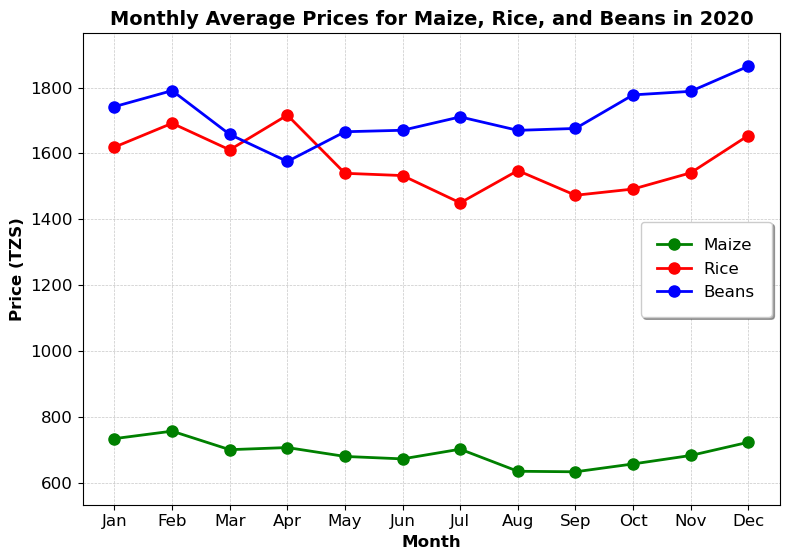

In [6]:
save_path = 'timeseries_graph/tz_food_price_graph.png'
#plot_maize_prices(maize_data, [(2010, 2011), (2012, 2013), (2014, 2015),(2019,2020),(2020,2021),(2022,2023)],plot_path)
prepare_and_plot_price_data_single_year(maize_data, rice_data, beans_data, 2020, save_path)

,year,region,district,maize_01,maize_02,maize_03,maize_04,maize_05,maize_06,maize_07,maize_08,maize_09,maize_10,maize_11,maize_12
0,2006,Arusha,Arusha,0.277,0.298,0.295,0.371,0.312,0.286,0.214,0.249,0.31,0.24,0.253,0.27
1,2007,Arusha,Arusha,0.277,0.298,0.295,0.371,0.312,0.286,0.214,0.249,0.31,0.24,0.253,0.27
2,2008,Arusha,Arusha,0.277,0.298,0.295,0.371,0.312,0.286,0.214,0.249,0.31,0.24,0.253,0.27
3,2009,Arusha,Arusha,0.277,0.298,0.295,0.371,0.312,0.286,0.214,0.249,0.31,0.24,0.253,0.27
4,2010,Arusha,Arusha,0.277,0.298,0.295,0.371,0.312,0.286,0.214,0.249,0.31,0.24,0.253,0.27


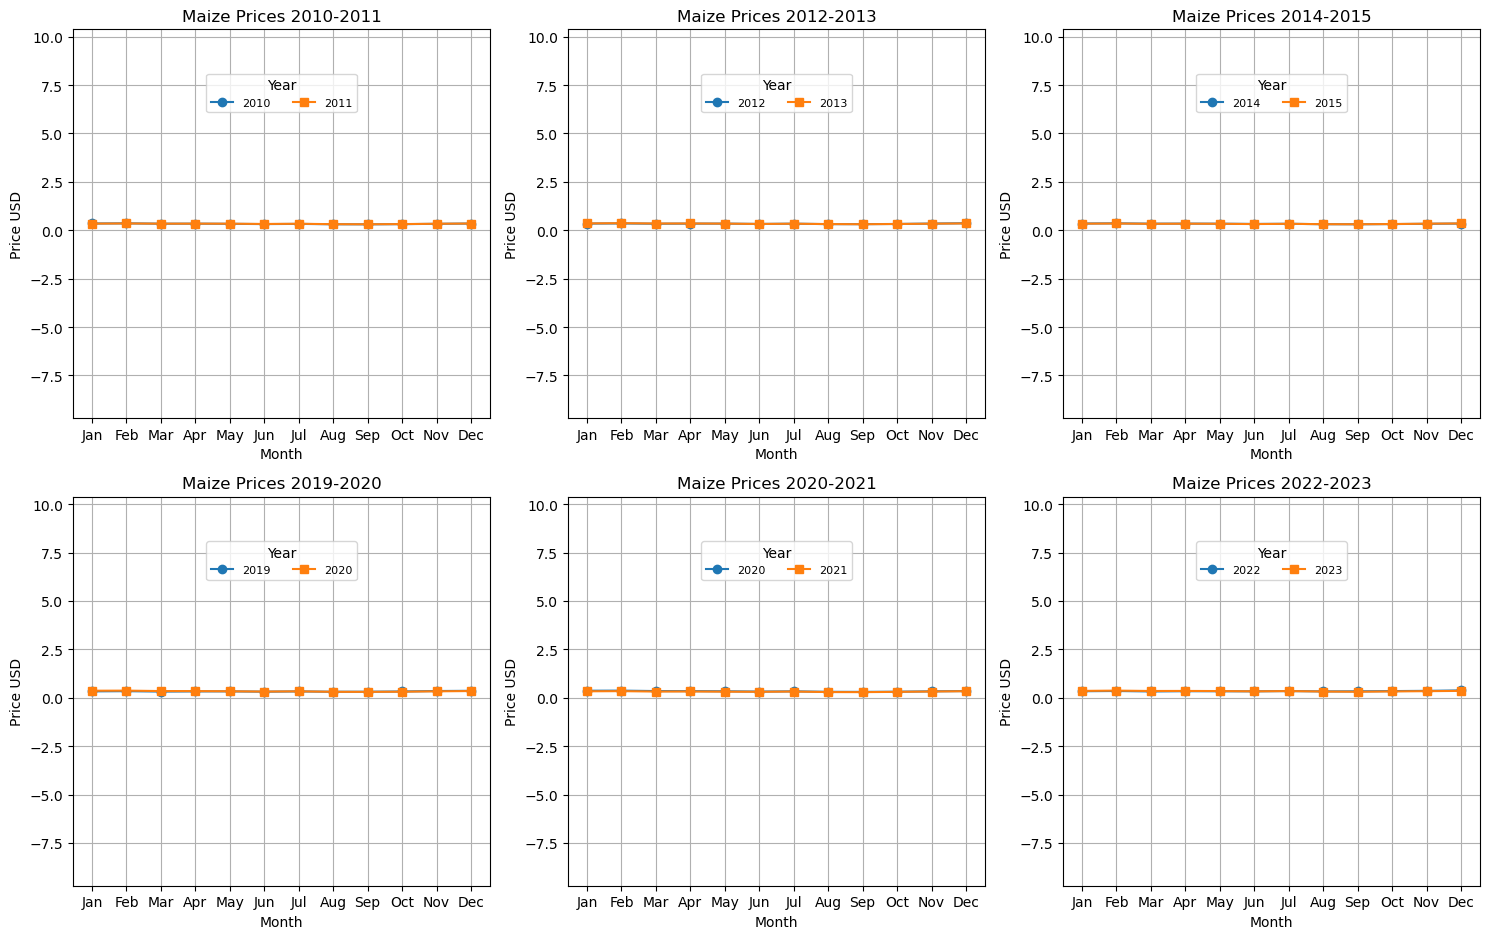

In [60]:
plot_path = 'timeseries_graph/tz_maize_graph_usd.png'
plot_maize_prices(maize_data, [(2010, 2011), (2012, 2013), (2014, 2015),(2019,2020),(2020,2021),(2022,2023)],plot_path)

## Rwanda Food Prices Data Preprocessing

In [8]:
rw_dir = 'rwanda_data/food_prices/'
shapefile = rw_dir + 'shapefiles/rw_district.shp'

In [9]:
f_maize= rw_dir + 'rw_maize.csv'
f_rice= rw_dir + 'rw_rice.csv'
f_beans= rw_dir + 'rw_beans.csv'
output_dir= rw_dir+ 'processed/'
files = [f_maize, f_rice, f_beans]
#process_food_prices(files, shapefile, output_dir, n_neighbors=5)

In [10]:
maize_data = read_csv(rw_dir+ 'processed/rw_maize_price.csv', delimiter = ',')
rice_data = read_csv(rw_dir+ 'processed/rw_rice_price.csv', delimiter = ',')
beans_data = read_csv(rw_dir+ 'processed/rw_beans_price.csv', delimiter = ',')
beans_data.head()

,year,province,district,beans_01,beans_02,beans_03,beans_04,beans_05,beans_06,beans_07,beans_08,beans_09,beans_10,beans_11,beans_12
0,2005,Amajyaruguru,Burera,399.056,312.084,332.85,371.45,383.572,376.226,351.434,362.774,400.304,433.566,417.616,399.484
1,2006,Amajyaruguru,Burera,399.056,312.084,332.85,371.45,383.572,376.226,351.434,362.774,400.304,433.566,417.616,399.484
2,2007,Amajyaruguru,Burera,399.056,312.084,332.85,371.45,383.572,376.226,351.434,362.774,400.304,433.566,417.616,399.484
3,2008,Amajyaruguru,Burera,399.056,312.084,332.85,371.45,383.572,376.226,351.434,362.774,400.304,433.566,417.616,399.484
4,2009,Amajyaruguru,Burera,399.056,312.084,332.85,371.45,383.572,376.226,351.434,362.774,400.304,433.566,417.616,399.484


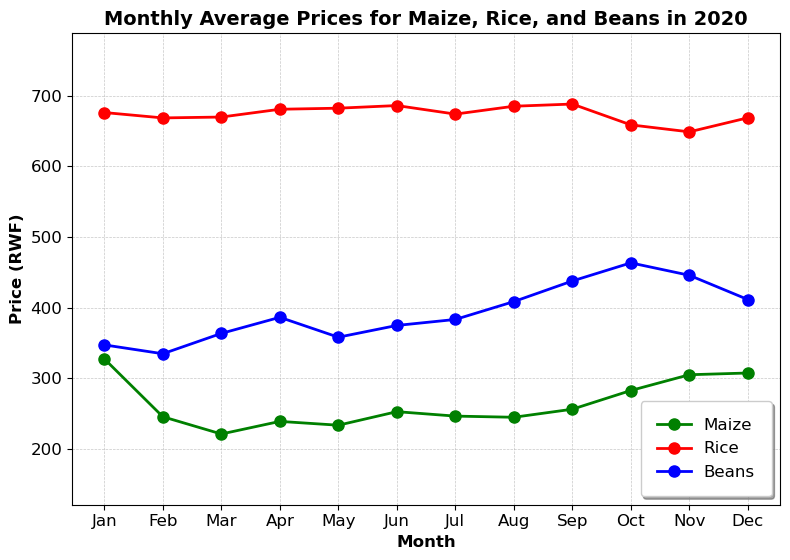

In [11]:
save_path = 'timeseries_graph/rw_food_price_graph.png'
#plot_maize_prices(maize_data, [2006, 2012, 2015, 2018, 2021],plot_path)
prepare_and_plot_price_data_single_year(maize_data, rice_data, beans_data, 2020, save_path)